In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from sklearn import model_selection
from pyBKT.models import Model
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.manifold import spectral_embedding
from scipy import linalg
from scipy.sparse.csgraph import laplacian

# Data Preprocessing

In [30]:
# Load data
DATA_DIR = 'data' # You may change the directory

users = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR))
events = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR))
subtasks = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR), index_col=0)

In [31]:
# extract game_name and number_range from the events dataframe to match the subtasks dataframe (given the event_id)
game_name = subtasks.merge(events[['event_id', 'game_name']], on='event_id', how='left').game_name
number_range = subtasks.merge(events[['event_id', 'number_range']], on='event_id', how='left').number_range

#split the game_name into skills
game_in_skill = {'Number representation': ['Subitizing', 'Conversion', 'Estimation', 'Estimation on Number Line', 'Scale: Conversion', 'Landing'], 'Number comparison/manipulation': ['Comparison', 'Secret Number', 'Distance', 'Scale: Composition', 'Order'], 'Addition/Substraction': ['Scale: Decomposition', 'Scale: Subtraction', 'Scale: Subtraction by Tens and Ones', 'Sliderule', 'Plus-minus', 'Difference', 'Completion', 'Calculator'], 'Multiplication/Division': ['Write as multiplication', 'Shelf: Jump Ahead', 'Shelf: given height', 'Shelf: random height', 'Distribution', 'Calculator: Multiplication', 'Calculator: Multiplication with ?', 'Calculator: Division', 'Jump backwards', 'Series']}
skill = game_name.apply(lambda x: 'Number representation' if x in game_in_skill['Number representation']
                        else 'Number comparison/manipulation' if x in game_in_skill['Number comparison/manipulation']
                        else 'Addition/Substraction' if x in game_in_skill['Addition/Substraction']
                        else 'Multiplication/Division' if x in game_in_skill['Multiplication/Division']
                        else 'Other')
# concatenate skills and number range and add it to the subtasks dataframe
subtasks['skill_name'] = skill + ' ' + number_range

In [32]:
display(subtasks.head(10))

,event_id,user_id,aim,answer,answerMode,availableNumbers,correct,correctAnswerObject,correctNumber,destination,...,subtask_finished_timestamp,target,timeoutInSeconds,timeoutInSteps,type,upperBound,divisor,orderIndependent,step,skill_name
subtask_id,,,,,,,,,,,,,,,,,,,,,
0,0,1,NaN,4,NaN,NaN,True,4,4.00000,NaN,...,2022-11-02T08:39:24.930Z,NaN,NaN,NaN,ConciseSubitizingTaskDescription,NaN,NaN,NaN,NaN,Number representation R10
1,0,1,NaN,1,NaN,NaN,True,NaN,NaN,NaN,...,2022-11-02T08:39:24.930Z,NaN,0.00000,2.00000,ConciseTimeoutDescription,NaN,NaN,NaN,NaN,Number representation R10
2,1,1,NaN,3,NaN,NaN,True,3,NaN,ARABIC,...,2022-11-11T10:26:49.007Z,NaN,NaN,NaN,ConciseConversionTaskDescription,NaN,NaN,NaN,NaN,Number representation R10
3,2,1,NaN,5,NaN,NaN,True,5,NaN,EXPLODED_BEAM,...,2022-11-18T10:34:12.191Z,NaN,NaN,NaN,ConciseConversionTaskDescription,NaN,NaN,NaN,NaN,Number representation R10
4,3,1,3.00000,"{'a': 2, 'b': 2.0402703}",NaN,NaN,False,"{'a': 3, 'b': 3.0}",NaN,NaN,...,2022-11-25T10:32:56.805Z,NaN,NaN,NaN,ConciseLandingTaskDescription,3.50000,NaN,NaN,NaN,Number representation R10
5,4,1,NaN,9,NaN,NaN,True,9,NaN,EXPLODED_BEAM,...,2022-12-02T10:44:49.621Z,NaN,NaN,NaN,ConciseConversionTaskDescription,NaN,NaN,NaN,NaN,Number representation R10
6,5,1,NaN,7,NaN,NaN,False,9,NaN,ARABIC,...,2022-12-09T10:12:26.729Z,NaN,NaN,NaN,ConciseConversionTaskDescription,NaN,NaN,NaN,NaN,Number representation R10
7,6,1,NaN,16,NaN,NaN,True,16,NaN,NaN,...,2022-12-16T10:25:45.293Z,NaN,NaN,NaN,ConciseSetComparisonTaskDescription,NaN,NaN,NaN,NaN,Number comparison/manipulation R20
8,6,1,NaN,1.3659,NaN,NaN,True,NaN,NaN,NaN,...,2022-12-16T10:25:45.293Z,NaN,4.00000,0.00000,ConciseTimeoutDescription,NaN,NaN,NaN,NaN,Number comparison/manipulation R20


In [33]:
def create_iterator(data):
    '''
    Create an iterator to split interactions in data into train and test, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index))
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values
    return model_selection.GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0).split(X, groups=groups)

# Data splitting in train, validation and test data
# Obtain indexes
train_index, test_index = next(create_iterator(subtasks))
# Split the data
subtasks_train, subtasks_test = subtasks.iloc[train_index], subtasks.iloc[test_index]

'''
# Split train data in train and validation sets
# Obtain indexes for necessary validation set
train_val_index, val_index = next(create_iterator(subtasks_train))
# Split the training data into training and validation
subtasks_train_val, subtasks_val = subtasks_train.iloc[train_val_index], subtasks_train.iloc[val_index]
'''

'\n# Split train data in train and validation sets\n# Obtain indexes for necessary validation set\ntrain_val_index, val_index = next(create_iterator(subtasks_train))\n# Split the training data into training and validation\nsubtasks_train_val, subtasks_val = subtasks_train.iloc[train_val_index], subtasks_train.iloc[val_index]\n'

# BKT model predictions

In [34]:
# Fit the model
modelBKT = {}
skills = subtasks['skill_name'].unique()
for skill in skills:
    modelBKT[skill] = Model(seed=0, defaults={'order_id' : 'subtask_id'})
    modelBKT[skill].fit(data=subtasks_train[subtasks_train['skill_name'] == skill], forgets = True)

In [35]:
# Make prediction dataset
proba_dataset = {}
proba_test = {}
for skill in skills:
    proba_dataset[skill] = modelBKT[skill].predict(data=subtasks_train[subtasks_train['skill_name'] == skill])[['user_id', 'correct_predictions']]
    proba_test[skill] = modelBKT[skill].predict(data=subtasks_test[subtasks_test['skill_name'] == skill])[['user_id', 'correct_predictions', 'skill_name']]

    # Add the attempt number
    proba_dataset[skill]['attempt'] = proba_dataset[skill].groupby(by = "user_id").cumcount()

proba_dataset['Number representation R10']

,user_id,correct_predictions,attempt
subtask_id,,,
0,1,0.56668,0
1,1,0.65907,1
2,1,0.68686,2
3,1,0.69375,3
4,1,0.69538,4
...,...,...,...
54994,997,0.56668,0
54995,997,0.60954,1
54996,997,0.67301,2


# Clustering on smaller dataframe

In [48]:
def plot_students(small, skill, barplot=True):
    """
    Plot the students time-series
    :param data: panda dataframe with students' time-series
    :return:
    """
    #students, biweeks = data.shape
    fig, axs = plt.subplots(5, 10, figsize=(16, 10), sharex=True,
                            sharey=True, facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for i,user in enumerate(user_ids):
        data = small[small['user_id']==user]
        if barplot :
            sns.barplot(data=data,x='subtask_id',y='correct_predictions',color='blue',ax=axs[i])
        else :
            sns.scatterplot(data=small[small['user_id']==user],x=range(data.shape[0]),y='correct_predictions',color='blue',ax=axs[i])
        axs[i].set_ylim([0, 1])
        axs[i].set_title('Student {0}'.format(user))
    fig.suptitle(skill)
    plt.show()
    #fig.text(0.5, 0.09, 'Biweek', va='center', ha='center', fontsize=14)
    #fig.text(0.09, 0.5, 'Usage of platform (hours)', va='center', ha='center', rotation='vertical', fontsize=14)

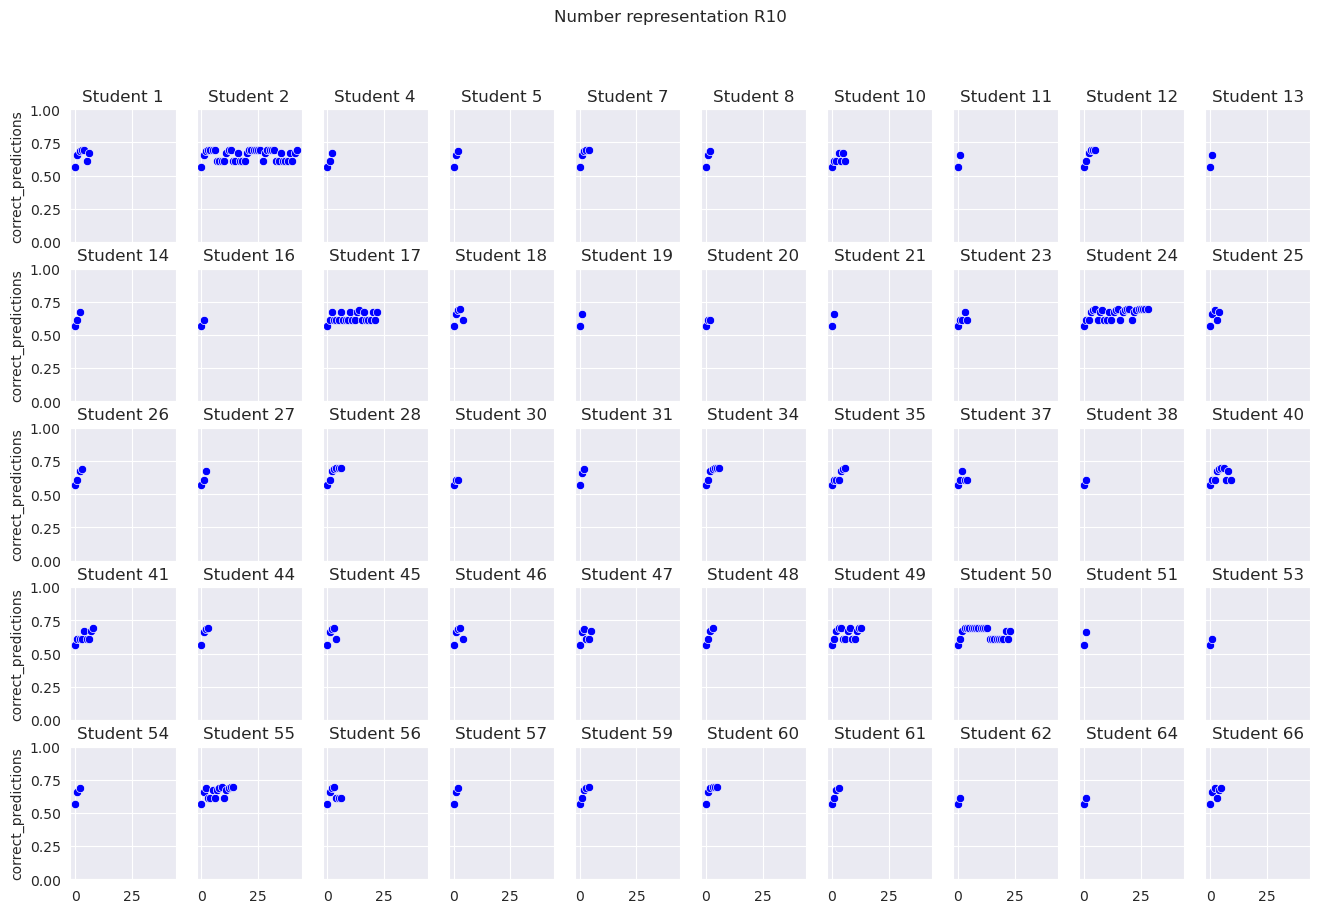

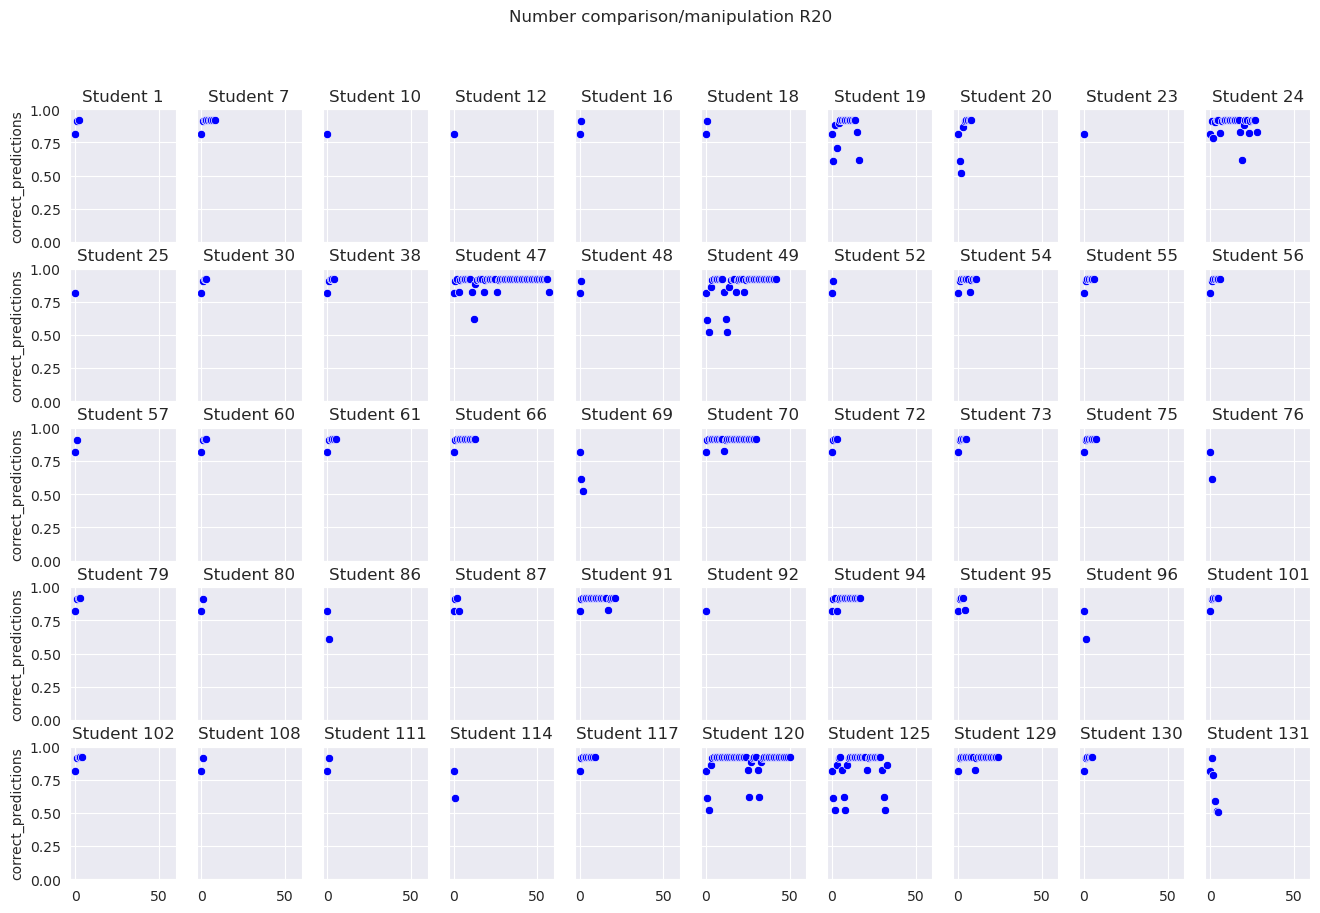

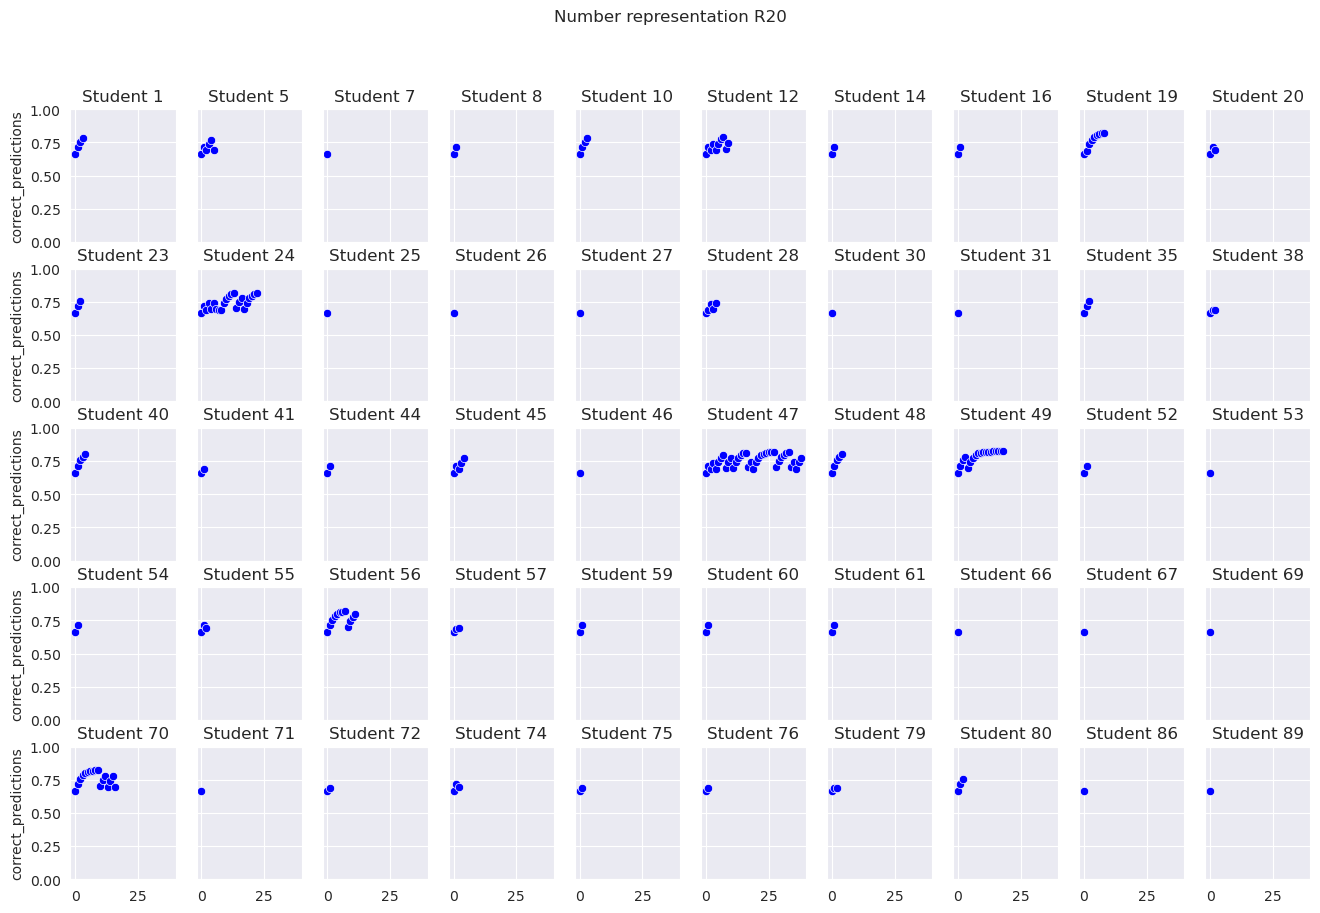

In [52]:
# Create smaller dataframe
for skill in skills[0:3] :
    # Get the user ids of the first 10 users
    user_ids = proba_dataset[skill]['user_id'].unique()[:50]

    # Filter the dataframe to only include rows corresponding to the first 10 users
    small = proba_dataset[skill][proba_dataset[skill]['user_id'].isin(user_ids)]
    small.reset_index(inplace=True)
    #display(small)
    plot_students(small,skill, barplot=False)

<Axes: xlabel='attempt', ylabel='correct_predictions'>

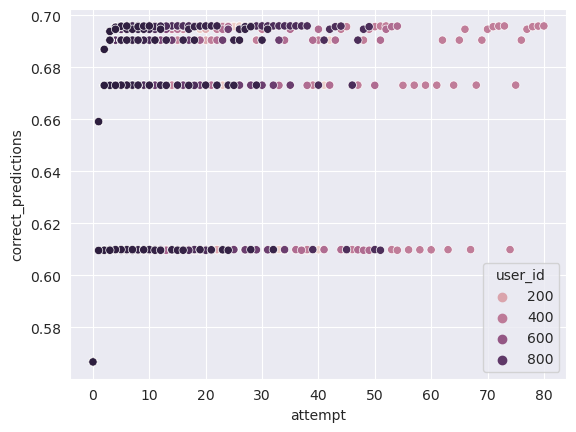

In [57]:
sns.scatterplot(data=proba_dataset['Number representation R10'],x='attempt',y='correct_predictions',color='blue', hue ='user_id')

In [ ]:
def get_adjacency(S, connectivity='full'):
    """
    Computes the adjacency matrix
    :param S: np array of similarity matrix
    :param connectivity: type of connectivity
    :return: adjacency matrix
    """

    if(connectivity=='full'):
        adjacency = S
    elif(connectivity=='epsilon'):
        epsilon = 0.5
        adjacency = np.where(S > epsilon, 1, 0)
    else:
        raise RuntimeError('Method not supported')

    return adjacency

In [ ]:
def spectral_clustering(W, n_clusters, random_state=111):
    """
    Spectral clustering
    :param W: np array of adjacency matrix
    :param n_clusters: number of clusters
    :return: tuple (kmeans, proj_X, eigenvals_sorted)
        WHERE
        kmeans scikit learn clustering object
        proj_X is np array of transformed data points
        eigenvals_sorted is np array with ordered eigenvalues

    """
    # Compute eigengap heuristic
    L = laplacian(W, normed=True)  #Compute the unnormalized graph laplacian
    eigenvals, _ = linalg.eig(L)
    eigenvals = np.real(eigenvals)
    eigenvals_sorted = eigenvals[np.argsort(eigenvals)]

    # Create embedding
    random_state = np.random.RandomState(random_state)
    proj_X = spectral_embedding(W, n_components=n_clusters,
                              random_state=random_state,
                              drop_first=False)

    # Cluster the points using k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state = random_state)
    kmeans.fit(proj_X)

    return kmeans, proj_X, eigenvals_sorted